In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import cv2
import math

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import pandas as pd
from tqdm import tqdm
 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
#Get all classes 
main_data_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/'
all_classes_names = os.listdir(main_data_dir)

In [11]:
image_height, image_width = 128, 128
num_classes = 51
frames_per_video = 200
batch_size = 16
epochs = 20

In [10]:
# Function to extract frames from a video
def extract_frames(video_path, skip=9):
    """
    video_path: str
    skip: int
    given a video path, return frames in regular intervals.
    Returns: A sequence of images. For instance, when skip=9, returns every 10th frame of the video
    """
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        frames_list.append(normalized_frame)
    frames_list = [frame for i, frame in enumerate(frames_list) if i % (skip+1) == 0]
    video_reader.release()
    return np.array(frames_list)

In [53]:
def encoded_video_frame_generator(encoder, video_paths, labels, batch_size=16, max_frames=200, image_height=128, image_width=128):
    """
    Yields batches of frames and corresponding labels from video files.
    """
    while True:
        X, y = [], []
        for i in tqdm(range(batch_size)):
            video_idx = np.random.randint(0, len(video_paths))
            video_path = video_paths[video_idx]
            label = labels[video_idx]
            
            frames = extract_frames(video_path)
                
            if frames is not None:
                # Initialize a padded array of zeros
                padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                
                # Copy the frames into the padded array, truncating if necessary
                num_frames = min(len(frames), max_frames)
                padded_frames[:num_frames] = frames[:num_frames]
                encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                X.append(np.squeeze(encoded_frames, axis=1))
                y.append(label)  # Append label as-is or pad if needed for sequences
        
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [52]:
def videos_to_encodings(encoder, video_paths, labels, skip_frames=4, max_frames=20, image_height=128, image_width=128):
    """
    Yields encoded videos and corresponding labels from all video paths provided.
    """
    while True:
        X, y = [], []
        with tqdm(total=len(labels)) as pbar:
            for video_path, label in zip(video_paths, labels):
                frames = extract_frames(video_path, skip=skip_frames)    
                if frames is not None:
                    # Initialize a padded array of zeros
                    padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                    # Copy the frames into the padded array, truncating if necessary
                    num_frames = min(len(frames), max_frames)
                    padded_frames[:num_frames] = frames[:num_frames]
    
                    # encode frames with pretrained image encoder
                    encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                    X.append(np.squeeze(encoded_frames, axis=1))
                    y.append(label)  # Append label as-is or pad if needed for sequences
                    pbar.update(1)
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [8]:
# Prepare paths and labels for training and testing
video_paths_train = [os.path.join(main_data_dir, cls, f) 
                     for cls in all_classes_names 
                     for f in os.listdir(os.path.join(main_data_dir, cls)) 
                     if "training" in f]

labels_train = [all_classes_names.index(cls) 
                for cls in all_classes_names 
                for f in os.listdir(os.path.join(main_data_dir, cls)) 
                if "training" in f]

video_paths_test = [os.path.join(main_data_dir, cls, f) 
                    for cls in all_classes_names 
                    for f in os.listdir(os.path.join(main_data_dir, cls)) 
                    if "testing" in f]

labels_test = [all_classes_names.index(cls) 
               for cls in all_classes_names 
               for f in os.listdir(os.path.join(main_data_dir, cls)) 
               if "testing" in f]

print(f"Total Training Videos: {len(video_paths_train)}, Total Test Videos: {len(video_paths_test)}")

Total Training Videos: 5215, Total Test Videos: 1551


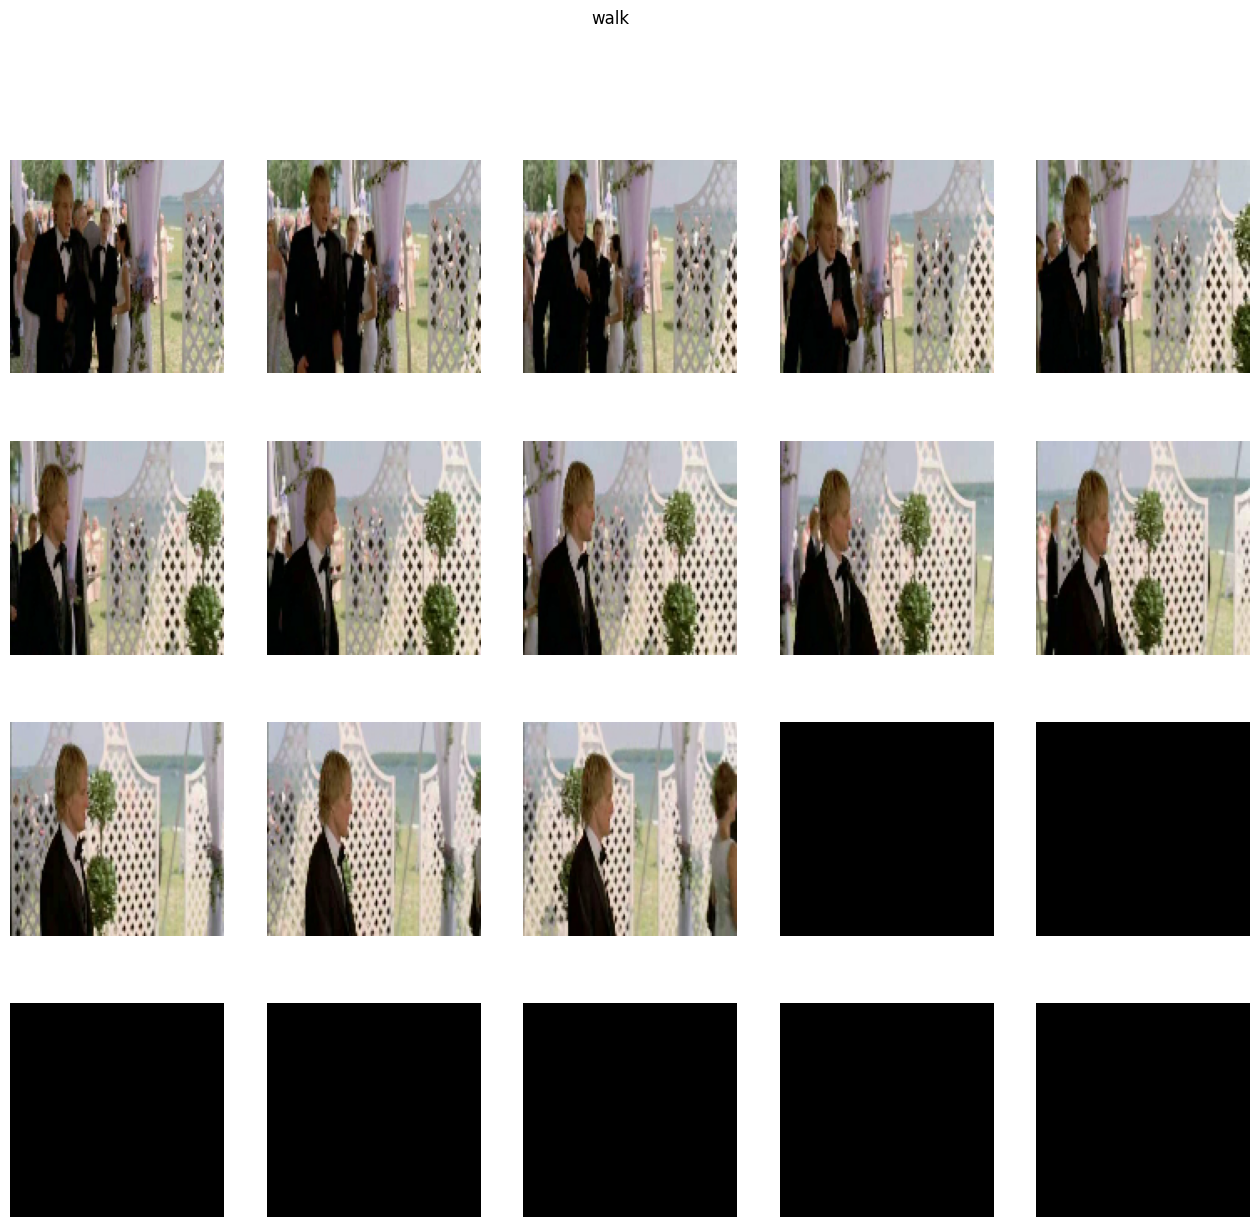

In [14]:
def plot_frame_sequence(vid_path, title):
    # pad frames
    frames = extract_frames(vid_path, skip=5)
    max_frames = 20
    padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
    num_frames = min(len(frames), max_frames)
    padded_frames[:num_frames] = frames[:num_frames]
    
    fig, ax = plt.subplots(4,5, figsize=(16,14))
    _ = plt.suptitle(title)
    for i, frame in enumerate(padded_frames):
        frame
        row = i // 5
        col = i % 5
        ax[row,col].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[row,col].set_axis_off()
    fig.show()
    
id = np.random.randint(5215)
vid_path = video_paths_train[id]
plot_frame_sequence(vid_path, all_classes_names[labels_train[id]])

In [56]:
pretrained_image_classifier = keras.models.load_model("/kaggle/input/vgg16_fine_tuned_img_enc/keras/hmdb51_8k_train/1/img_enc.h5")
img_enc = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Ensure input shape matches your image size
    *pretrained_image_classifier.layers[:-1]  # Exclude the final output layer
])
img_enc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,648 (60.16 MB)

 Trainable params: 1,056,960 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [57]:
# encoded generators
frames_per_video = 20
encode_train_set = videos_to_encodings(img_enc, video_paths_train, labels_train)
encode_test_set = videos_to_encodings(img_enc, video_paths_test, labels_test)

In [75]:
# load training data from raw videos to encoder outputs
X_train, y_train = next(encode_train_set)
X_train.shape

100%|██████████| 5215/5215 [36:40<00:00,  2.37it/s]


(5215, 20, 64)

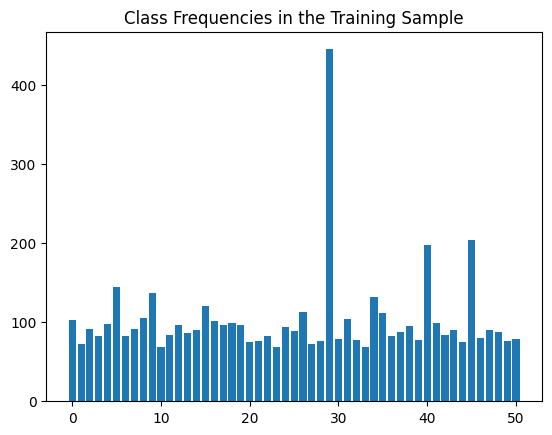

In [138]:
class_counts = np.unique(y_train, return_counts=True)
_ = plt.bar(x=class_counts[0], height=class_counts[1])
_ = plt.title("Class Frequencies in the Training Sample")

In [49]:
# load training data set from memory:
train_df = pd.read_csv("/kaggle/input/encoded-hmdb51/encoded_videos_20_frames_subsample_every_5th.csv")
# train_df.head()
X_train, y_train = (
    train_df.iloc[:,2:-2].to_numpy(dtype=np.float64).reshape(5215, 20, 64), # X_train
    train_df.loc[:,"class"].to_numpy(dtype=np.int32)[range(0,train_df.shape[0],20)]) # y_train (label as integer)
print("### Training Data ###")
print(X_train.shape)
print(y_train)
# sanity check if conversion worked:
print(ds[0,0,:])
print(train_df.iloc[0,2:-2])
print("### Labels ###")
print(f"Converted Length labels:{len(y_train)}, Converted Data: {y_train}") # length should be 5215

### Training Data ###
(5215, 20, 64)
[ 0  0  0 ... 50 50 50]
[2.5502555 3.5672426 5.4337335 4.290614 5.0019636 5.0533323 3.5100365
 0.84406775 2.13275 6.6250567 4.4789734 0.0 0.0 0.0 3.0585268 0.0 0.0
 3.2742186 6.6297693 5.2828383 5.900191 2.79456 1.7425119 0.0 0.0 4.616623
 2.3074324 4.9005265 2.1029508 1.864776 3.9564888 4.7881203 2.9159498 0.0
 4.809629 5.493023 7.1913195 3.422579 5.8914456 3.6486957 0.0 0.076629505
 0.0 7.7071233 2.5501995 0.0 0.0 0.18186451 4.84549 5.8418846 3.8124733
 2.6265783 0.0 4.436124 0.0 4.206206 3.350025 0.0 0.0 0.0 0.0 4.7391977
 0.0 2.5583622]
feature_0     2.550256
feature_1     3.567243
feature_2     5.433733
feature_3     4.290614
feature_4     5.001964
                ...   
feature_59         0.0
feature_60         0.0
feature_61    4.739198
feature_62         0.0
feature_63    2.558362
Name: 0, Length: 64, dtype: object
### Labels ###
Converted Length labels:5215, Converted Data: [ 0  0  0 ... 50 50 50]


In [72]:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(y_train.shape[0]).batch(50)
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size=0.8, right_size=0.2)

### Base-Model Performance (Image-encoder only)

We can simply reuse the encoder generator which will give us predictions for each image of the training set.

In [124]:
predictions_img_encoder = videos_to_encodings(pretrained_image_classifier, video_paths_test, labels_test)
y_pred, _ = next(predictions_img_encoder)

100%|██████████| 1551/1551 [11:33<00:00,  2.24it/s]


This will yield 20 predictions per testing sample since the image encoder was trained on frames (images) rather than sequences of frames, we will have to come up with a way to combine the predictions of the image encoder for each individual frame into a prediction for the whole sequence of frames. The simplest way to do this is to take the largest probability assigned to each frame as the prediction and then find the class which was predicted most often as the prediction for the sequence.

In [143]:
pred_per_sequence = []
for sequence in y_pred:
    pred_classes, pred_counts = np.unique(np.argmax(sequence, axis=1), return_counts=True)
    most_frequent_prediction = pred_classes[np.argmax(pred_counts)]
    pred_per_sequence.append(most_frequent_prediction)

encoder_accuracy = np.mean(y_test == np.array(pred_per_sequence))
print(f"Base-line Accuracy on test set: {encoder_accuracy}")

Base-line Accuracy on test set: 0.571244358478401


### RCNN (CNN: VGG-16-image-encoder, RNN-type: LSTM)

In [115]:
def compile_and_train_model(model, optimizer, train, val, epochs: int, callbacks: list, verbose=2):
    """
        model: A keras.Model
        optimizer: which training optimizer to use, e.g., "adam"
        train: training set
        val: validation set
        epochs: how many epochs to train the model for
        callbacks: list of call backs such as early stopping
        
        returns: tuple of model, training history, and final validation set accuracy
    """
    # compile
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # train
    train_hist = model.fit(
        train,
        epochs=100,
        validation_data=val,
        callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=verbose),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
        verbose=verbose
    )

    # evaluate final values
    val_acc = model.evaluate(val_ds, verbose=verbose)

    return (model, train_hist, val_acc)

def plot_training_history(train_hist, model_name:str):
    """
    Plots the training graph for accuracy and loss with model_name as suptitle.
    """
    history_frame = pd.DataFrame(train_hist.history)

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle(model_name)
    ax[0].plot(history_frame.index, history_frame['accuracy'], label='train')
    ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='val')
    _ = ax[0].set_xlabel('Epoch')
    _ = ax[0].set_ylabel('Accuracy')
    _ = ax[0].legend(loc='lower right')
    _ = ax[0].set_title("Accuracy Curve")
    
    ax[1].plot(history_frame.index, history_frame['loss'], label='train')
    ax[1].plot(history_frame.index, history_frame['val_loss'], label='val')
    _ = ax[1].set_xlabel('Epoch')
    _ = ax[1].set_ylabel('Loss')
    _ = ax[1].legend(loc='upper right')
    _ = ax[1].set_title("Loss Curve")
    fig.show()

In [ ]:
# best parameter search:
dropouts = [0.1, 0.15, 0.2]
lstm_sizes = [128, 256, 512]
hyper_parameter_search = pd.DataFrame(columns=["dropout","lstm size", "val accuracy"])
with tqdm(total=(len(dropouts)*len(lstm_sizes))) as pbar:
    for dropout in [0.05, 0.1, 0.15, 0.2]:
        for lstm_size in [128, 256, 512]:
            img_enc_lstm = keras.Sequential([
                layers.LSTM(lstm_size, return_sequences=False, recurrent_dropout=dropout, dropout=dropout),
                layers.Dense(256, activation="relu"),
                layers.Dropout(dropout),
                layers.Dense(256, activation="relu"),
                layers.Dropout(dropout),
                layers.Dense(num_classes, activation="softmax")  
            ])
            _, _, val_metrics = compile_and_train_model(img_enc_lstm, 
                optimizer='adam', 
                train = train_ds,
                val = val_ds,
                epochs=100, 
                callbacks = [
                    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=0),
                    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
                ],
                verbose=0
            )
            hyper_parameter_search.loc[hyper_parameter_search.shape[0],:] = [dropout, lstm_size, val_metrics[1]]
            pbar.update(1)
hyper_parameter_search.sort_values("val accuracy", ascending=False)

In [148]:
img_enc_lstm = keras.Sequential([
    layers.LSTM(128, return_sequences=False, recurrent_dropout=0.15),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_lstm(np.expand_dims(X_train[0], axis=0))

print(img_enc_lstm.summary())

img_enc_lstm, hist, val_acc = compile_and_train_model(
    img_enc_lstm, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=100, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    ],
    verbose=1
)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (1, 256)               │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (1, 51)                │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,739 (823.20 KB)

 Trainable params: 210,739 (823.20 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0778 - loss: 3.7584 - val_accuracy: 0.1822 - val_loss: 2.9547 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1861 - loss: 2.9995 - val_accuracy: 0.3145 - val_loss: 2.4380 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2859 - loss: 2.5480 - val_accuracy: 0.4151 - val_loss: 2.1013 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3510 - loss: 2.2811 - val_accuracy: 0.4516 - val_loss: 1.8982 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4111 - loss: 2.0436 - val_accuracy: 0.4919 - val_loss: 1.7637 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4432 - loss: 1.9049 - val_accuracy: 0.5091 - val_loss: 1.6563 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4700 - loss: 1.76

Final Validation Loss: 1.309863567352295, Final Validation Accuracy: 0.6442952752113342


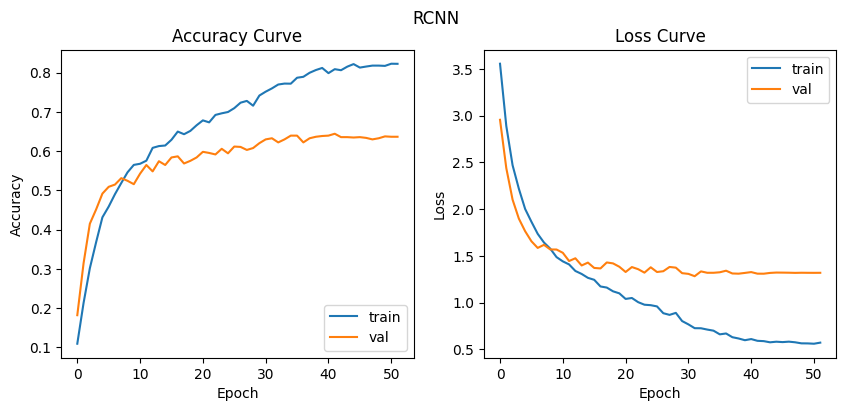

In [149]:
plot_training_history(hist, "RCNN")
print(f"Final Validation Loss: {val_acc[0]}, Final Validation Accuracy: {val_acc[1]}")

In [151]:
# Evaluate the model
train_evaluation = img_enc_lstm.evaluate(train_ds)
print(f"Train Loss: {train_evaluation[0]}, Train Accuracy: {train_evaluation[1]}")
val_evaluation = img_enc_lstm.evaluate(val_ds)
print(f"Val Loss: {val_evaluation[0]}, Val Accuracy: {val_evaluation[1]}")
test_evaluation = img_enc_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_evaluation[0]}, Test Accuracy: {test_evaluation[1]}")
print(f"Averaged Accuracy over all 3 splits: {np.mean([test_evaluation[1], val_evaluation[1], train_evaluation[1]])}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8804 - loss: 0.4213
Train Loss: 0.4162081182003021, Train Accuracy: 0.8775168061256409
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6426 - loss: 1.2972
Val Loss: 1.309863567352295, Val Accuracy: 0.6442952752113342
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7095 - loss: 1.2631
Test Loss: 1.3521538972854614, Test Accuracy: 0.6847195625305176
Averaged Accuracy over all 3 splits: 0.7355105479558309


In [91]:
# save training data for reuse:
data = X_train
# Reshape the data: (5212 samples, 20 sequence rows, 64 features)
num_samples, num_sequences, num_features = data.shape
reshaped_data = data.reshape(-1, num_features)  # Shape: (5212 * 20, 64)

# Create MultiIndex: Sample and Sequence Row
sample_index = np.repeat(np.arange(num_samples), num_sequences)  # [0,0,0,...,1,1,1,...]
sequence_index = np.tile(np.arange(num_sequences), num_samples)  # [0,1,2,...,0,1,2,...]

# Combine into a MultiIndex
multi_index = pd.MultiIndex.from_arrays([sample_index, sequence_index], names=["sample", "sequence_row"])

# Create the DataFrame
df = pd.DataFrame(reshaped_data, index=multi_index, columns=[f"feature_{i}" for i in range(num_features)])
df["class"] = [label for label in y_train for i in range(20)]
df["class_name"] = [all_classes_names[label] for label in y_train for i in range(20)]

df.to_csv("encoded_videos_20_frames_subsample_every_5th.csv")


### RCNN with Bi-LSTM

In [158]:
img_enc_bilstm = keras.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=False, recurrent_dropout=0.2)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_bilstm(np.expand_dims(X_train[0], axis=0))
print(img_enc_bilstm.summary())

img_enc_bilstm, bi_hist, bi_val_acc = compile_and_train_model(
    img_enc_bilstm, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=100, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
    verbose=1
    )

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (1, 256)               │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (1, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (1, 51)                │        13,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,323 (1.31 MB)

 Trainable params: 342,323 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.1019 - loss: 3.5939 - val_accuracy: 0.3231 - val_loss: 2.4858 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2888 - loss: 2.5315 - val_accuracy: 0.3988 - val_loss: 2.0547 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4020 - loss: 2.1087 - val_accuracy: 0.4545 - val_loss: 1.8010 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4604 - loss: 1.8882 - val_accuracy: 0.4957 - val_loss: 1.6861 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5091 - loss: 1.7114 - val_accuracy: 0.5101 - val_loss: 1.6183 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5263 - loss: 1.5677 - val_accuracy: 0.5360 - val_loss: 1.5471 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5766 - loss: 1.47

Final Validation Loss: 1.2903003692626953, Final Validation Accuracy: 0.665388286113739


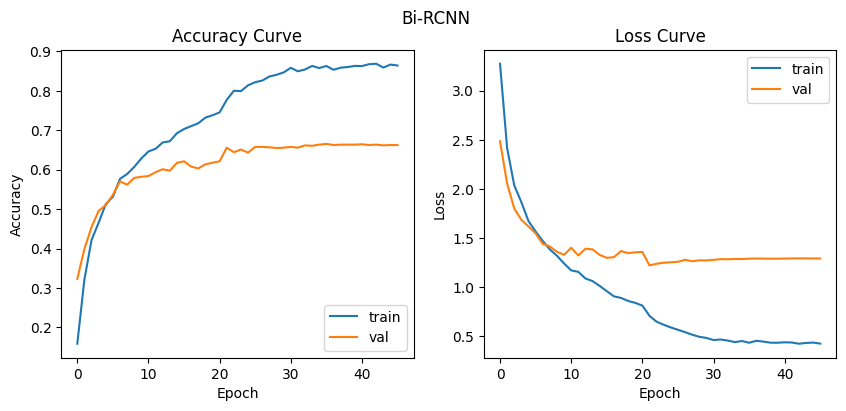

In [159]:
plot_training_history(bi_hist, "Bi-RCNN")
print(f"Final Validation Loss: {bi_val_acc[0]}, Final Validation Accuracy: {bi_val_acc[1]}")

In [160]:
# Evaluate the model
train_evaluation = img_enc_bilstm.evaluate(train_ds)
print(f"Train Loss: {train_evaluation[0]}, Train Accuracy: {train_evaluation[1]}")
val_evaluation = img_enc_bilstm.evaluate(val_ds)
print(f"Val Loss: {val_evaluation[0]}, Val Accuracy: {val_evaluation[1]}")
test_evaluation = img_enc_bilstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_evaluation[0]}, Test Accuracy: {test_evaluation[1]}")
print(f"Averaged Accuracy over all 3 splits: {np.mean([test_evaluation[1], val_evaluation[1], train_evaluation[1]])}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9063 - loss: 0.3201
Train Loss: 0.30755066871643066, Train Accuracy: 0.9098753333091736
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6673 - loss: 1.2649
Val Loss: 1.2903003692626953, Val Accuracy: 0.665388286113739
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7222 - loss: 1.1261
Test Loss: 1.2250007390975952, Test Accuracy: 0.7034171223640442
Averaged Accuracy over all 3 splits: 0.759560247262319


### Error Analysis

                precision    recall  f1-score   support

     kick_ball       0.79      0.60      0.68        25
         catch       0.70      0.87      0.78        30
    shoot_ball       0.85      0.82      0.84        40
  climb_stairs       0.88      0.70      0.78        30
         punch       0.68      0.75      0.71        28
         stand       0.19      0.30      0.23        10
         smoke       0.59      0.81      0.69        27
          clap       0.84      0.82      0.83        38
    somersault       0.61      0.54      0.58        35
         drink       0.35      0.41      0.38        27
        pushup       0.92      0.97      0.94        35
          push       0.78      0.78      0.78        32
          talk       0.67      0.70      0.68        23
       fencing       0.76      0.87      0.81        30
          golf       0.71      1.00      0.83        15
   shake_hands       0.79      0.80      0.80        41
         sword       0.62      0.58      0.60  

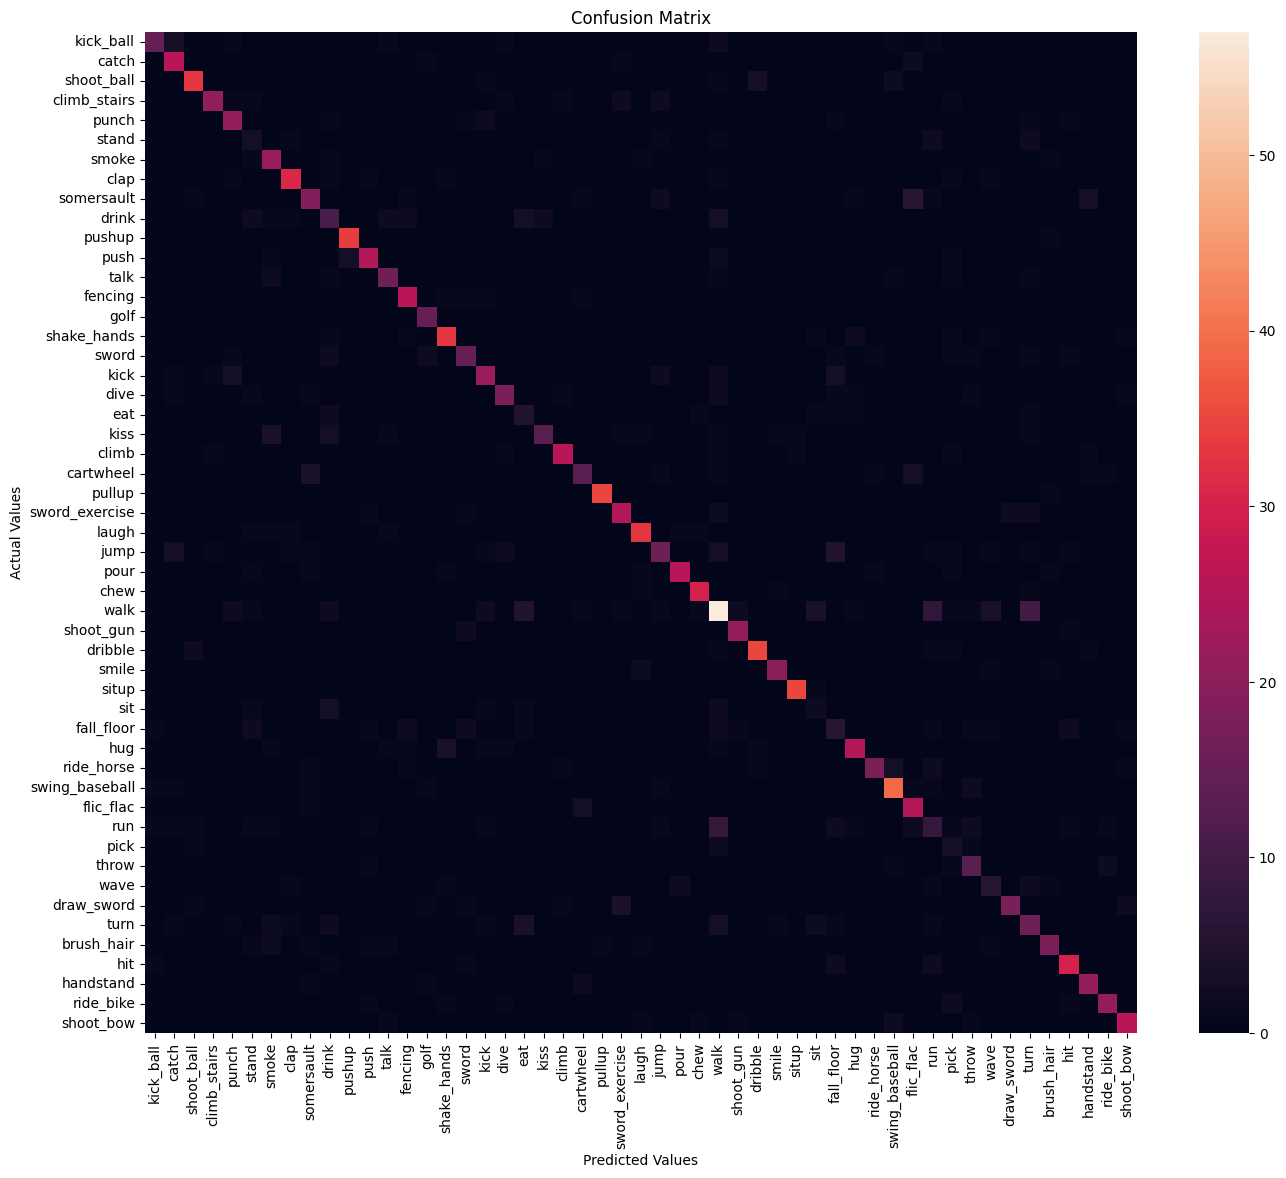

In [162]:
y_true = y_test
y_pred = np.argmax(img_enc_bilstm(X_test), axis=1)

print(classification_report(y_true, y_pred, target_names=all_classes_names))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm,
                     index = all_classes_names, 
                     columns = all_classes_names)
_ = plt.figure(figsize=(16,13))
_ = sns.heatmap(cm_df)
_ = plt.title('Confusion Matrix')
_ = plt.ylabel('Actual Values')
_ = plt.xlabel('Predicted Values')

### Data Leakage
We found that our data set contained some videos of the same person across training and testing set. Therefore, our training and testing data are not independent of each other. This is an example of group leakage (https://en.wikipedia.org/wiki/Leakage_(machine_learning)#Training_example_leakage) and means that our model can obtain good results by memorizing features that are specific to this person (e.g., shirt color, background) rather than specific to this action (brushing hair).

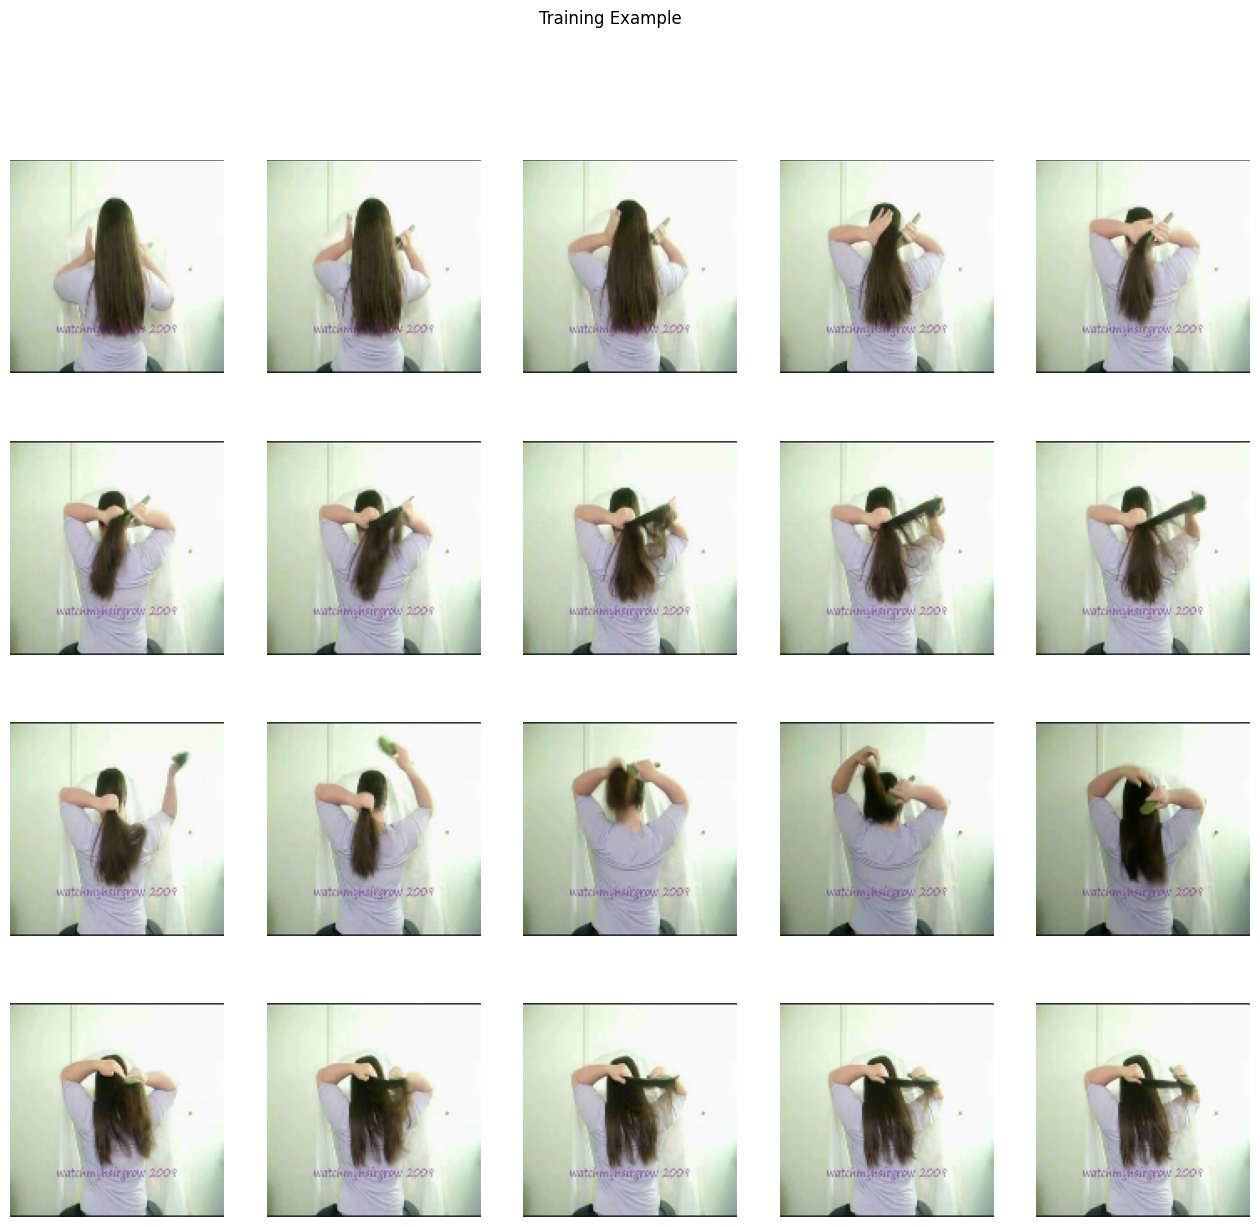

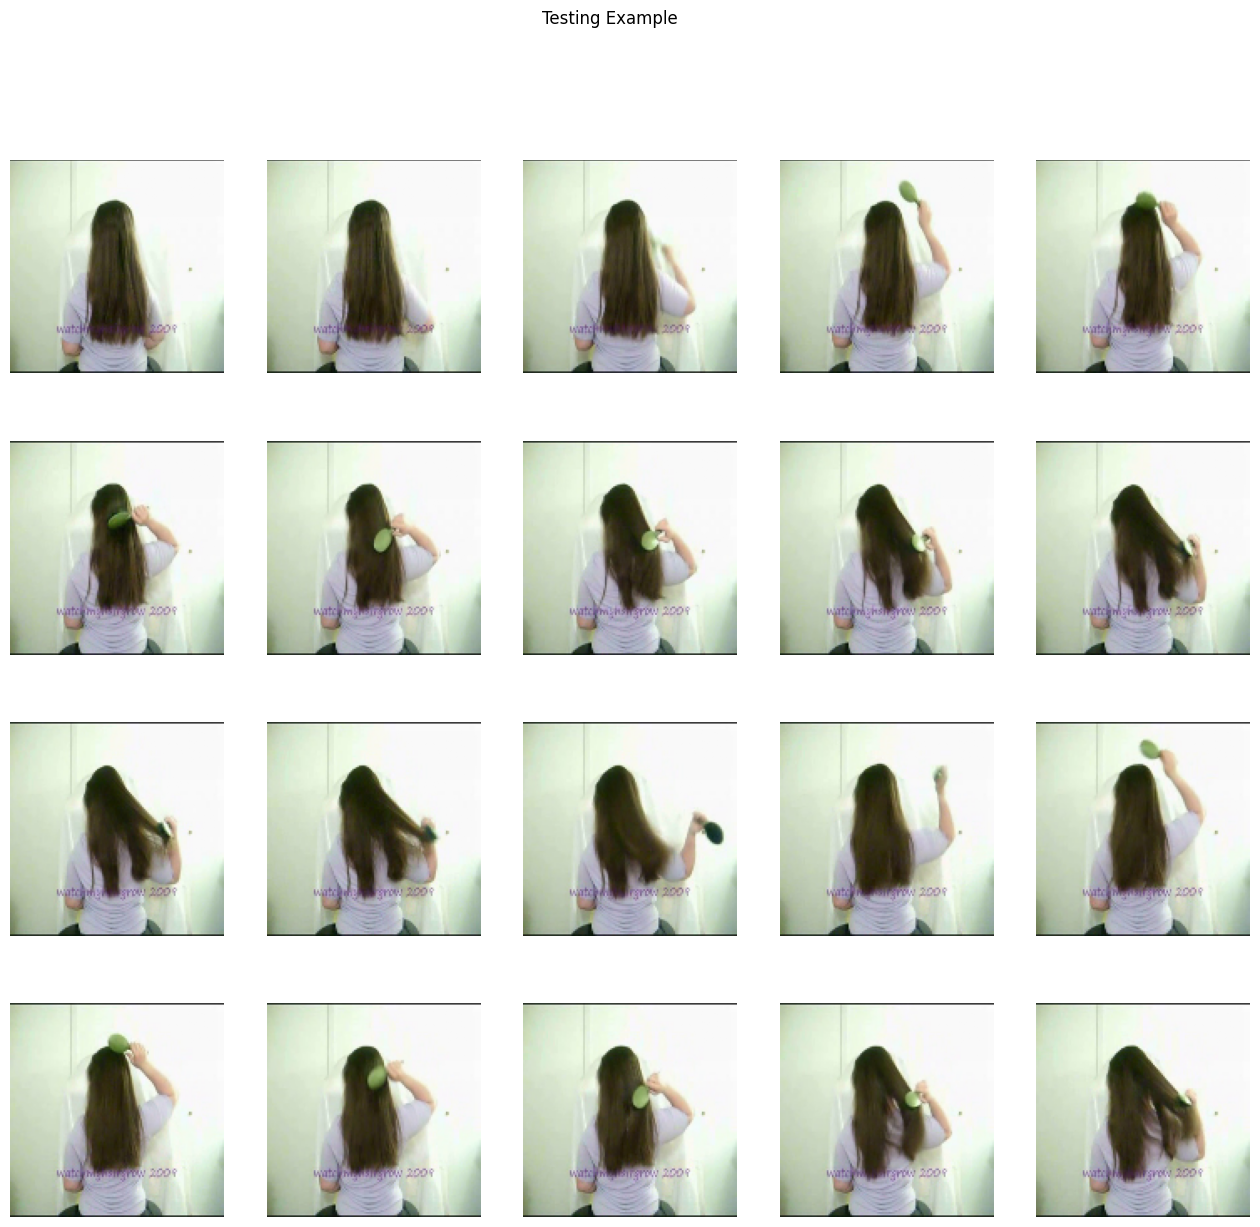

In [15]:
training_brush = "/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/brush_hair/training_1.avi"
plot_frame_sequence(training_brush, "Training Example")
testing_brush ="/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/brush_hair/testing_1.avi"
plot_frame_sequence(testing_brush, "Testing Example")